# Course 7 [Self-paced]: Data Streaming with PySpark

## 1. Streaming Data

### What is streaming?

Streaming data is data that is generated continuously by thousands of data sources, which typically send in the data records simultaneously, and in small sizes (KBs). It can be log files generated by customers using mobile or web apps, e-commerce purchases, in-game player activity, information from social networks, financial trading floors, geospatial services, or telemetry from connected devices.

This data needs to be processed sequentially and incrementally on a record-by-record basis or over sliding time windows, and used for a wide variety of analytics including correlations, aggregations, filtering, and sampling.

### Benefit of streaming data

Streaming data processing is beneficial in most scenarios where new, dynamic data is generated on a continual basis.

- Companies generally begin with simple applications such as collecting system logs and rudimentary processing like rolling min-max computation.
- Then, applications evolve to more sophisticated near-real-time processing. From producing simple reports and performing simple actions in response (e.g., emitting alarms) to performing more sophisticated forms of data analysis, ML, and extract deeper insights from the data.

## 2. Spark Streaming

### What is Spark Streaming?

Spark Streaming is an extension of the core Spark API that enables scalable and fault-tolerant stream processing of live data streams.

Fundamental concepts of Spark Streaming include:

- Discretized Streams
- Caching
- Checkpointing

### Discretized Streams

Discretized Stream (DStreams), represent a continuous stream of data. Here, either the data stream is receieved directly from any source or is received after we have done some processing on the original data.

The very first step of building a streaming application is to define the batch duration for the data source from which we are collecting the data. If the batch duration is 2 seconds, then the data will be collected every 2 seconds and stored in an RDD. And the chain of continuous series of these RDDs is a DStream which is immutable and can be used as a distributed dataset by Spark.

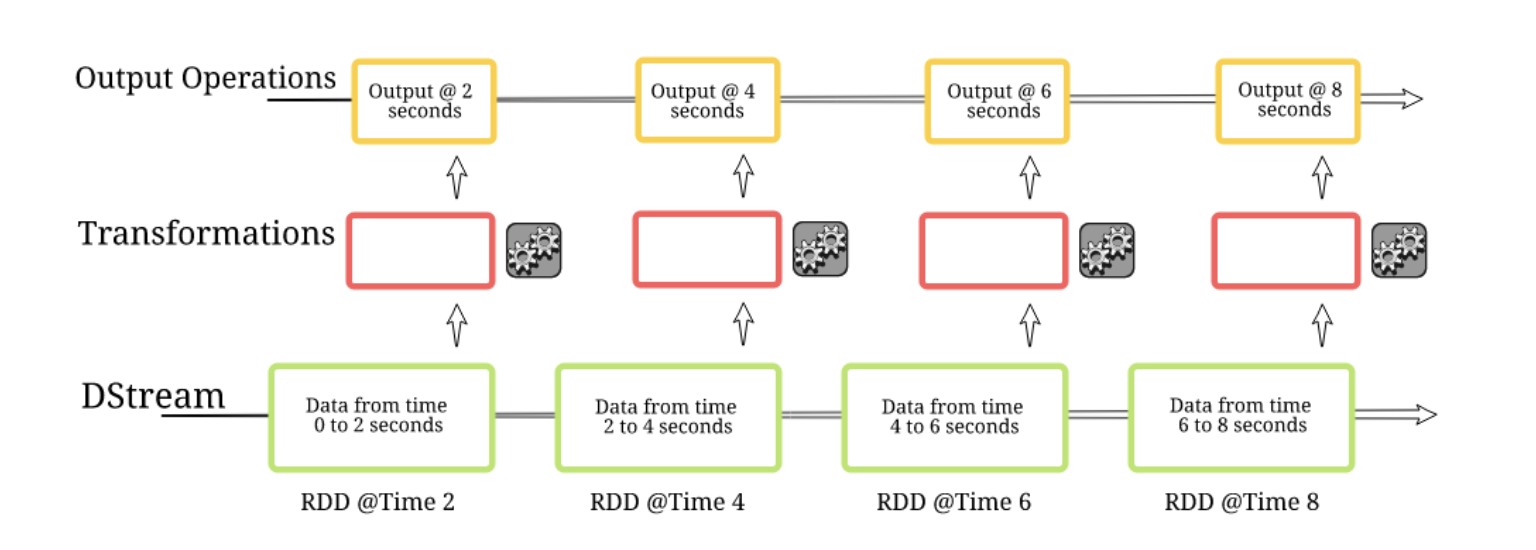

### Caching

We want our Spark application to run 24/7 and whenever any fault occurs, we want it to recover as soon as possible. But while working with data at a massive scale, Spark needs to recompute all the transformations again in case of any fault.

To deal with this challenge, we can store the results we have calculated temporarily (cached) to maintain the resulst of the transformations that are defined on this data.

### Checkpointing

Checkpoint is another technique to keep the results of the transformed dataframes. It saves the state of the running application from time to time on any reliable storage like HDFS. However, it is slower and less flexible than caching.

## 3. Shared Variables in Streaming Data

The concepts of consolidating and broadcasting has been mentioned in Part 7, 8 from Course 3, so I don't remention it here.

## 4. Performing Social Bot Classification on Streaming Data using PySpark

In [1]:
# Required libraries
import pyspark.sql.functions as F

from pyspark import SparkContext

from pyspark.sql import SparkSession, Row
from pyspark.sql.types import *

from pyspark.streaming import StreamingContext

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StopWordsRemover, Word2Vec, RegexTokenizer
from pyspark.ml.classification import LogisticRegression

import sys

In [2]:
from pyspark.sql import SparkSession

# Create SparkSession from builder
# If the sample data you work with is small, you can remove the `.config` call
spark = SparkSession.builder.appName('Spark').config("spark.driver.memory", "5g").config("spark.driver.cores", 2).config("spark.executor.cores", 2).getOrCreate()
sc = spark.sparkContext

23/03/31 17:18:24 WARN Utils: Your hostname, Mufins-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.21 instead (on interface en0)
23/03/31 17:18:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/31 17:18:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Define the schema
tweet_schema = StructType([
    StructField('attachments', StringType(), True),
    StructField('author_id', LongType(), True),
    StructField('context_annotations', StringType(), True),
    StructField('conversation_id', LongType(), True),
    StructField('created_at', StringType(), True),
    StructField('entities', StructType([
        StructField('hashtags', ArrayType(StructType([
            StructField('indices', ArrayType(LongType(), True), True),
            StructField('text', StringType(), True)]), True), True),
        StructField('media', ArrayType(StructType(
            [StructField('display_url', StringType(), True),
             StructField('expanded_url', StringType(), True),
             StructField('id', LongType(), True),
             StructField('id_str', StringType(), True),
             StructField('indices', ArrayType(LongType(), True), True),
             StructField('media_url', StringType(), True),
             StructField('media_url_https', StringType(), True),
             StructField('sizes', StructType([
                 StructField('large', StructType([
                     StructField('h', LongType(), True),
                     StructField('resize', StringType(), True),
                     StructField('w', LongType(), True)]
                 ), True),
                 StructField('medium', StructType([
                     StructField('h', LongType(), True),
                     StructField('resize', StringType(), True),
                     StructField('w', LongType(), True)
                 ]), True),
                 StructField('small', StructType([
                     StructField('h', LongType(), True),
                     StructField('resize', StringType(), True),
                     StructField('w', LongType(), True)
                 ]), True),
                 StructField('thumb', StructType([
                     StructField('h', LongType(), True),
                     StructField('resize', StringType(), True),
                     StructField('w', LongType(), True)
                 ]), True)
             ]), True),
             StructField('source_status_id', LongType(), True),
             StructField('source_status_id_str', StringType(), True),
             StructField('source_user_id', LongType(), True),
             StructField('source_user_id_str', StringType(), True),
             StructField('type', StringType(), True),
             StructField('url', StringType(), True)
            ]), True), True),
        StructField('symbols', ArrayType(StructType([
            StructField('indices', ArrayType(LongType(), True), True),
            StructField('text', StringType(), True)
        ]), True), True),
        StructField('urls', ArrayType(StructType([
            StructField('display_url', StringType(), True),
            StructField('expanded_url', StringType(), True),
            StructField('indices', ArrayType(LongType(), True), True),
            StructField('url', StringType(), True)
        ]), True), True),
        StructField('user_mentions', ArrayType(StructType([
            StructField('id', LongType(), True),
            StructField('id_str', StringType(), True),
            StructField('indices', ArrayType(LongType(), True), True),
            StructField('name', StringType(), True),
            StructField('screen_name', StringType(), True)
        ]), True), True)]), True),
    StructField('geo', StructType([
        StructField('coordinates', ArrayType(StringType(), True), True), StructField('type', StringType(), True)
    ]), True),
    StructField('id', StringType(), True),
    StructField('in_reply_to_user_id', LongType(), True),
    StructField('lang', StringType(), True),
    StructField('possibly_sensitive', BooleanType(), True),
    StructField('public_metrics', StructType([
        StructField('like_count', LongType(), True),
        StructField('quote_count', StringType(), True),
        StructField('reply_count', StringType(), True),
        StructField('retweet_count', LongType(), True)
    ]), True),
    StructField('referenced_tweets', StringType(), True),
    StructField('reply_settings', StringType(), True),
    StructField('source', StringType(), True),
    StructField('text', StringType(), True),
    StructField('withheld', StringType(), True)
])

label_schema = StructType([
    StructField('id', StringType(), False),
    StructField('label', StringType(), False)
])

In [4]:
# Read the dataset
tweet_df = spark.read.json('partitioned/tweet_1_par_0.json', schema=tweet_schema)
label_df = spark.read.csv('label.csv', header=True)

In [5]:
def add_u_prefix(text):
    return 'u' + text

udfAddPrefix = F.udf(add_u_prefix, StringType())

tweet_df = tweet_df.select('author_id', 'text')
tweet_df = tweet_df.withColumn('author_id_str', F.col('author_id').cast('string'))
tweet_df = tweet_df.withColumn('author_id_str_prefix', udfAddPrefix(F.col('author_id_str')))

label_df = label_df.withColumn('label', F.col('label') == 'bot')

In [6]:
# Inner join
full_df = tweet_df.select('author_id_str_prefix', 'text').join(label_df, tweet_df.author_id_str_prefix == label_df.id, 'left').select('text', 'label')
full_df = full_df.withColumn('label', F.col('label').cast('integer'))
full_df.show(5)

+--------------------+-----+
|                text|label|
+--------------------+-----+
|RT @EENet_news: P...|    0|
|@Lenniesaurus Peo...|    0|
|RT @G_S_Bhogal: 6...|    0|
|RT @AtholBond: Gr...|    0|
|RT @DrDollySud_Ph...|    0|
+--------------------+-----+
only showing top 5 rows



In [11]:
full_df.count()

100000

No data


No data


No data


In [7]:
# Define a 4-stage processor

# Stage 1: Tokenize the tweet text
stage_1 = RegexTokenizer(inputCol='text', outputCol='tokens', pattern='\\W')

# Stage 2: Remove the stop words
stage_2 = StopWordsRemover(inputCol='tokens', outputCol='filtered_words')

# Stage 3: Create a word vector of size 100
stage_3 = Word2Vec(inputCol='filtered_words', outputCol='vector', vectorSize=100)

# Stage 4: Logistic Regression model
model = LogisticRegression(featuresCol='vector', labelCol='label')

23/03/31 17:18:29 WARN StopWordsRemover: Default locale set was [en_VN]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


In [8]:
# Setup the pipeline
pipeline = Pipeline(stages=[stage_1, stage_2, stage_3, model])

# Fit the pipeline model with the training data
piped = pipeline.fit(full_df)

23/03/31 17:18:33 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/03/31 17:18:33 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/03/31 17:18:33 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [9]:
def get_prediction(tweet_texts):
    try:
        # Filter the tweets whose length is greater than 0
        tweet_texts = tweet_texts.filter(lambda x: len(x) > 0)
        
        # Create a dataframe with column name 'text' and each row will contain the tweet
        rowRdd = tweet_texts.map(lambda w: Row(text=w))
        
        # Create Spark dataframe
        wordsDataFrame = spark.createDataFrame(rowRdd)
        
        # Transform the data using the pipeline and get the predicted sentiment
        piped.transform(wordsDataFrame).select('text', 'prediction').show()
    except:
        print('No data')

In [10]:
# Initialize the streaming context
ssc = StreamingContext(sc, batchDuration=60)

# Create a DStream that will connect to <hostname>:<port>
lines = ssc.socketTextStream('localhost', 9991)

# Split the tweet text
words = lines.flatMap(lambda line: line.split("\n"))

# Get the predicted results for the tweets received
words.foreachRDD(get_prediction)

# Start the computation
ssc.start()

# Wait for the computation to terminate
ssc.awaitTermination()

23/03/31 17:18:54 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
23/03/31 17:18:54 WARN BlockManager: Block input-0-1680257934600 replicated to only 0 peer(s) instead of 1 peers


+--------------------+----------+
|                text|prediction|
+--------------------+----------+
|     This is a tweet|       0.0|
|This is another t...|       0.0|
|This is the third...|       0.0|
|I believe that th...|       0.0|
+--------------------+----------+



No data


23/03/31 17:20:06 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
23/03/31 17:20:06 WARN BlockManager: Block input-0-1680258006600 replicated to only 0 peer(s) instead of 1 peers
23/03/31 17:20:09 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
23/03/31 17:20:09 WARN BlockManager: Block input-0-1680258009200 replicated to only 0 peer(s) instead of 1 peers
23/03/31 17:20:13 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
23/03/31 17:20:13 WARN BlockManager: Block input-0-1680258012800 replicated to only 0 peer(s) instead of 1 peers
23/03/31 17:20:18 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
23/03/31 17:20:18 WARN BlockManager: Block input-0-1680258017800 replicated to only 0 peer(s) instead of 1 peers
23/03/31 17:20:36 WARN RandomBlockReplicationPolicy: Expecting 1 replicas with only 0 peer/s.
23/03/31 17:20:36 WARN BlockManager: Block input-0-1680258036000 replicated to

+--------------------+----------+
|                text|prediction|
+--------------------+----------+
|I am testing anot...|       0.0|
|      Hope it's okay|       0.0|
|         Or it's not|       0.0|
|     Don't know then|       0.0|
|       1 2 3 4 5 6 7|       0.0|
+--------------------+----------+



No data


ERROR:root:KeyboardInterrupt while sending command.                 (0 + 1) / 1]
Traceback (most recent call last):
  File "/Users/mufin/opt/anaconda3/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/mufin/opt/anaconda3/lib/python3.9/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/Users/mufin/opt/anaconda3/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 